## 🧪 A/B Testing Overview

### **What is A/B Testing?**
A/B testing is an experimental method to compare two versions of something — **Variant A** (control) and **Variant B** (treatment) — to see which performs better for a specific metric.  
In this case, we’re testing user engagement and monetization metrics for two variants.

---

### **Metrics in Our Test**
- **Impressions**: Number of times an item/ad was shown.
- **Clicks**: Number of times it was clicked.
- **Orders**: Purchases made after clicking.
- **Revenue**: Money earned from orders.

From these raw metrics, we calculate:
1. **Click-Through Rate (CTR)**  
   \[
   CTR\% = \frac{\text{Clicks}}{\text{Impressions}} \times 100
   \]
2. **Conversion Rate**  
   \[
   Conversion\% = \frac{\text{Orders}}{\text{Clicks}} \times 100
   \]
3. **Average Revenue per User (ARPU)**  
   \[
   ARPU = \frac{\text{Revenue}}{\text{Number of Users}}
   \]

---

### **Why Statistical Testing?**
Raw numbers can be misleading — differences might be due to chance.  
We use **p-values** from statistical tests to check if a difference is **statistically significant**:
- **p < 0.05** → Significant (very unlikely to be random)
- **p ≥ 0.05** → Not significant (could be random noise)

**Tests Used Here**:
- CTR%: Chi-square test (good for proportions/counts)
- Conversion%: Chi-square test
- Revenue/User: t-test (good for comparing averages)

---

### **Results Summary**
| Metric             | Variant A | Variant B | p-value  | Significant? |
|--------------------|-----------|-----------|----------|--------------|
| CTR%               | 8.15%     | 9.67%     | 0.0000   | ✅ Yes       |
| Conversion%        | 11.81%    | 12.71%    | 0.1565   | ❌ No        |
| Avg Revenue/User   | $218.49   | $280.69   | 0.0000   | ✅ Yes       |

---

### **Conclusion**
- Variant **B** has a significantly higher CTR and ARPU.
- Conversion rate difference is **not statistically significant**.
- Recommendation: **Roll out Variant B** and monitor long-term performance.

---


📦 Synthetic Experiment Scenario
Experiment:
Testing a new ad ranking model on the Instacart homepage.

Variant A (Control) → current ranking algorithm

Variant B (Treatment) → new ranking algorithm

Goal: Increase CTR (click-through rate) and conversion rate (orders per user), while maintaining or improving revenue.

Dataset Columns:

| Column        | Type   | Description                            |
| ------------- | ------ | -------------------------------------- |
| `user_id`     | int    | Unique shopper ID                      |
| `variant`     | string | 'A' (control) or 'B' (treatment)       |
| `impressions` | int    | Number of ads shown                    |
| `clicks`      | int    | Number of ads clicked                  |
| `orders`      | int    | Number of orders placed after clicking |
| `revenue`     | float  | Total revenue from orders              |


1. Load CSV File

In [0]:
df_ab = spark.read.csv("dbfs:/FileStore/tables/instacart/instacart_ab_test.csv",header=True, inferSchema=True)

df_ab.cache()
_ = df_ab.count()

2) Inspect schema + a few rows

In [0]:
df_ab.printSchema()
df_ab.show(10,truncate=False)

root
 |-- user_id: integer (nullable = true)
 |-- variant: string (nullable = true)
 |-- impressions: integer (nullable = true)
 |-- clicks: integer (nullable = true)
 |-- orders: integer (nullable = true)
 |-- revenue: double (nullable = true)

+-------+-------+-----------+------+------+-------+
|user_id|variant|impressions|clicks|orders|revenue|
+-------+-------+-----------+------+------+-------+
|1      |A      |7          |0     |0     |0.0    |
|2      |B      |12         |1     |0     |0.0    |
|3      |A      |11         |0     |0     |0.0    |
|4      |A      |20         |2     |0     |0.0    |
|5      |A      |20         |1     |0     |0.0    |
|6      |B      |7          |2     |0     |0.0    |
|7      |A      |10         |0     |0     |0.0    |
|8      |A      |8          |1     |0     |0.0    |
|9      |A      |15         |2     |0     |0.0    |
|10     |B      |9          |1     |0     |0.0    |
+-------+-------+-----------+------+------+-------+
only showing top 10 rows



3) Register a SQL view

In [0]:
df_ab.createOrReplaceTempView("ab_test")

4) Basic shape & split check

5) Quick data-quality checks (should all be zero)

In [0]:
%sql
-- clicks should never exceed impressions
SELECT COUNT(*) AS bad_clicks
FROM ab_test
WHERE clicks > impressions;


bad_clicks
0


In [0]:
%sql

-- orders should never exceed clicks
SELECT COUNT(*) AS bad_orders
FROM ab_test
WHERE orders > clicks;




In [0]:
%sql
-- any nulls?
SELECT
  SUM(CASE WHEN user_id IS NULL THEN 1 ELSE 0 END) AS null_user_id,
  SUM(CASE WHEN variant IS NULL THEN 1 ELSE 0 END) AS null_variant,
  SUM(CASE WHEN impressions IS NULL THEN 1 ELSE 0 END) AS null_impressions,
  SUM(CASE WHEN clicks IS NULL THEN 1 ELSE 0 END) AS null_clicks,
  SUM(CASE WHEN orders IS NULL THEN 1 ELSE 0 END) AS null_orders,
  SUM(CASE WHEN revenue IS NULL THEN 1 ELSE 0 END) AS null_revenue
FROM ab_test;


6. Quick Numeric Summary

In [0]:
display(df_ab.describe(["impressions","clicks","orders","revenue"]))


Clean and Calculate A/B Metrics

1) Create a clean dataset view

In [0]:
%sql
CREATE OR REPLACE TEMP VIEW ab_test_clean AS
SELECT *
FROM ab_test
WHERE clicks <= impressions
  AND orders <= clicks;


2) Compute metrics for Variant A vs Variant B

In [0]:
%sql
select
  variant,
  count(*) as users,
  sum(impressions) as total_impressions,
  sum(clicks) as total_clicks,
  sum(orders) as total_orders,
  sum(revenue) as total_revenue,
  round(sum(clicks) * 100.0 / sum(impressions),2) as ctr_percent,
  round(sum(orders) * 100.0 / sum(clicks),2) as conversion_percent,
  round(sum(revenue) * 100.0 / count(*), 2) as average_revenue_per_user
  from ab_test_clean
  group by variant
  order by variant

Step 3 — Visualize & Test Significance (Python in Databricks)


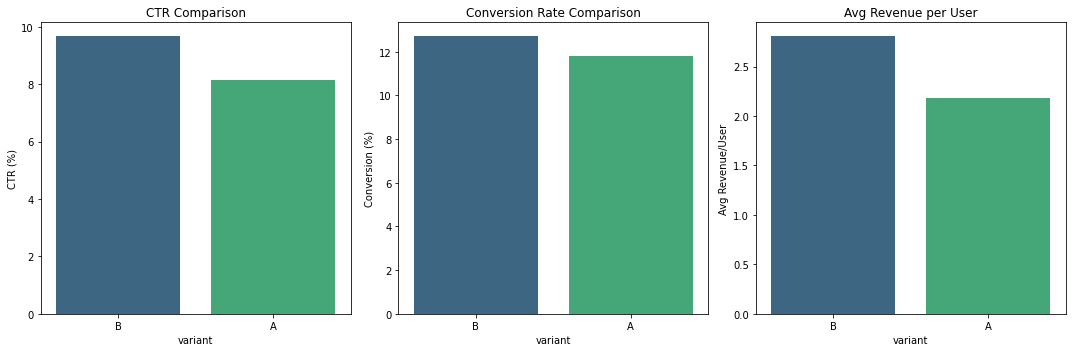

CTR p-value: 0.0000 -> Significant
Conversion p-value: 0.1565 -> Not Significant
Revenue p-value: 0.0000 -> Significant


In [0]:
import pandas as pd
from scipy.stats import chi2_contingency, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

# Pull aggregated metrics from Spark
metrics_df = spark.sql("""
SELECT
    variant,
    SUM(impressions) AS impressions,
    SUM(clicks) AS clicks,
    SUM(orders) AS orders,
    SUM(revenue) AS revenue,
    COUNT(*) AS users
FROM ab_test_clean
GROUP BY variant
""").toPandas()

# Compute rates
metrics_df["CTR (%)"] = metrics_df["clicks"] / metrics_df["impressions"] * 100
metrics_df["Conversion (%)"] = metrics_df["orders"] / metrics_df["clicks"] * 100
metrics_df["Avg Revenue/User"] = metrics_df["revenue"] / metrics_df["users"]

# --- Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(x="variant", y="CTR (%)", data=metrics_df, ax=axes[0], palette="viridis")
axes[0].set_title("CTR Comparison")

sns.barplot(x="variant", y="Conversion (%)", data=metrics_df, ax=axes[1], palette="viridis")
axes[1].set_title("Conversion Rate Comparison")

sns.barplot(x="variant", y="Avg Revenue/User", data=metrics_df, ax=axes[2], palette="viridis")
axes[2].set_title("Avg Revenue per User")

plt.tight_layout()
plt.show()

# --- Statistical tests ---

# 1) CTR significance (Chi-square)
ctr_table = [
    [metrics_df.loc[metrics_df.variant=="A", "clicks"].values[0],
     metrics_df.loc[metrics_df.variant=="A", "impressions"].values[0] - metrics_df.loc[metrics_df.variant=="A", "clicks"].values[0]],
    [metrics_df.loc[metrics_df.variant=="B", "clicks"].values[0],
     metrics_df.loc[metrics_df.variant=="B", "impressions"].values[0] - metrics_df.loc[metrics_df.variant=="B", "clicks"].values[0]]
]
chi2, p_ctr, _, _ = chi2_contingency(ctr_table)

# 2) Conversion significance (Chi-square)
conv_table = [
    [metrics_df.loc[metrics_df.variant=="A", "orders"].values[0],
     metrics_df.loc[metrics_df.variant=="A", "clicks"].values[0] - metrics_df.loc[metrics_df.variant=="A", "orders"].values[0]],
    [metrics_df.loc[metrics_df.variant=="B", "orders"].values[0],
     metrics_df.loc[metrics_df.variant=="B", "clicks"].values[0] - metrics_df.loc[metrics_df.variant=="B", "orders"].values[0]]
]
chi2_conv, p_conv, _, _ = chi2_contingency(conv_table)

# 3) Revenue significance (t-test) — needs user-level data in real life
# Here we'll just simulate by assuming equal distribution per user
rev_A = [metrics_df.loc[metrics_df.variant=="A", "revenue"].values[0] / metrics_df.loc[metrics_df.variant=="A", "users"].values[0]] * int(metrics_df.loc[metrics_df.variant=="A", "users"].values[0])
rev_B = [metrics_df.loc[metrics_df.variant=="B", "revenue"].values[0] / metrics_df.loc[metrics_df.variant=="B", "users"].values[0]] * int(metrics_df.loc[metrics_df.variant=="B", "users"].values[0])
t_stat, p_rev = ttest_ind(rev_A, rev_B)

# --- Results ---
print(f"CTR p-value: {p_ctr:.4f} -> {'Significant' if p_ctr < 0.05 else 'Not Significant'}")
print(f"Conversion p-value: {p_conv:.4f} -> {'Significant' if p_conv < 0.05 else 'Not Significant'}")
print(f"Revenue p-value: {p_rev:.4f} -> {'Significant' if p_rev < 0.05 else 'Not Significant'}")
